In [214]:
import numpy as np
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

#read images
data=[]
for i in range(10):
    img = cv2.imread('dataset/%s.jpg' %i)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (threshi, final_img) = cv2.threshold(img_gray, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    data.append(np.array(final_img, dtype=np.float32).flatten())



In [215]:
import torch
from torch.autograd import Variable

In [216]:
x_data = Variable(torch.Tensor([data]))
y_data = Variable(torch.Tensor([data]))
 
#single layer perceptron
class Perceptron(torch.nn.Module):
 
    def __init__(self):
        super(Perceptron, self).__init__()
        self.linear = torch.nn.Linear(256, 256)  # 256 in and 256 out
        self.sigmoid = torch.nn.Sigmoid() # activation function
    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out
 
slp_model = Perceptron()

In [217]:
#multi layer perceptron with a fully connected hidden layer
class MLP(torch.nn.Module):
 
    def __init__(self):
        super(MLP, self).__init__()
        self.linear = torch.nn.Linear(256, 256)  # 256 in and 256 out
        self.relu = torch.nn.ReLU()
        self.hidden = torch.nn.Linear(256, 256)  # 256 in and 256 out
        self.sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        inp = self.linear(x)
        hid = self.relu(inp)
        hid = self.hidden(hid)
        out = self.sigmoid(hid)
        return out
 
mlp_model = MLP()

In [218]:
#convert numpy array to 16x16 binary image
def generate_rescaled_inputs(data):
    input_data = []
    
    for i in range(10):
        p = data[i].reshape(16, 16)
        p[p <= 0.5] = 0
        p[p > 0.5] = 1
        input_data.append(p)
        
    return input_data

In [219]:
def generate_predictions(data, m):
    predicted_output = []
    
    for i in range(10):
        if m == 0:
            p = slp_model(Variable(torch.Tensor([data[i]]))).cpu().detach().numpy()
        else:
            p = mlp_model(Variable(torch.Tensor([data[i]]))).cpu().detach().numpy()
        p = p.reshape(16, 16)
        p[p <= 0.5] = 0
        p[p > 0.5] = 1
        predicted_output.append(p)
    
    return predicted_output

In [220]:
def calculate_total_black_pixels(array):
    count = 0
    for a in array:
            count+= np.count_nonzero(a==0)
    return count

In [221]:
def calculate_total_white_pixels(array):
    count = 0
    for a in array:
            count+= np.count_nonzero(a==1)
    return count

In [222]:
def calculate_matching_black_pixels(data1, data2):
    match_ctr = 0
    inp = data1.flatten()
    pred = data2.flatten()
    for i in range(256):
        match_ctr += 1 if(inp[i]==0 and pred[i]==0) else 0
    return match_ctr

In [223]:
def calculate_mismatching_black_pixels(data1, data2):
    mismatch_ctr = 0
    inp = data1.flatten()
    pred = data2.flatten()
    for i in range(256):
        mismatch_ctr += 1 if(inp[i]==1 and pred[i]==0) else 0
    return mismatch_ctr

In [224]:
def compute_error_metrics(input_data, predicted_output):
    f_h = []
    f_fa = []
    
    for ix, data in enumerate(input_data):
        total_black_pixels = calculate_total_black_pixels(input_data[ix])
        total_hits = calculate_matching_black_pixels(input_data[ix], predicted_output[ix])
        fh_ratio = float(total_hits/total_black_pixels)
        # print("Fraction of hits is ", total_hits, total_black_pixels)
        f_h.append(fh_ratio)
    
    for ix, data in enumerate(input_data):
        total_white_pixels = calculate_total_white_pixels(input_data[ix])
        total_fa = calculate_mismatching_black_pixels(input_data[ix], predicted_output[ix])
        ffa_ratio = float(total_fa/total_white_pixels)
        # print("Fraction of false alarms is ", total_fa, total_white_pixels)
        f_fa.append(ffa_ratio)
    return f_h, f_fa
    

In [225]:
from random import sample
def add_noise(data, sigma):
    idx = sample(range(256), 25)
    noise = np.random.normal(0, sigma, 25)
    for i in range(25):
        data[idx[i]] += noise[i]
    return data
def normalize(data):
    mini = np.amin(data)
    maxi = np.amax(data)
    for i in range(256):
        data[i] = (data[i] - mini)/(maxi - mini)
    return data

In [226]:
noisy_data = []
for d in data:
    nd = add_noise(np.copy(d), 0.1)
    noisy_data.append(normalize(nd))


In [227]:
for test in range(0, 200, 10):
    slp_model = Perceptron()
    
    criterion = torch.nn.MSELoss(size_average = False)
    optimizer = torch.optim.SGD(slp_model.parameters(), lr = 0.01)
    for epoch in range(test):
    
        # Forward pass: Compute predicted y by passing x to the model
        pred_y = slp_model(x_data)
    
        # Compute loss
        loss = criterion(pred_y, y_data)
    
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('epoch {}'.format(test))
    
    target_values = generate_rescaled_inputs(data)
    predicted_values = generate_predictions(data, 0)
    fh, ffa = compute_error_metrics(target_values, predicted_values)
    print('ffa=', np.mean(ffa))
    print('fh=', np.mean(fh))

/Users/shivambang/miniforge3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch 0
ffa= 0.47682316123585977
fh= 0.556019648146683
epoch 10
ffa= 0.029965983061805545
fh= 0.5922249687404847
epoch 20
ffa= 0.02600066426105685
fh= 0.7149075378601341
epoch 30
ffa= 0.01809817146869282
fh= 0.8215692017023803
epoch 40
ffa= 0.005752965291572147
fh= 0.922706562837007
epoch 50
ffa= 0.002628562822395422
fh= 0.9753754773220846
epoch 60
ffa= 0.0004405286343612335
fh= 0.987683284457478
epoch 70
ffa= 0.0
fh= 0.9954545454545455
epoch 80
ffa= 0.0
fh= 1.0
epoch 90
ffa= 0.0
fh= 1.0
epoch 100
ffa= 0.0
fh= 1.0
epoch 110
ffa= 0.0
fh= 1.0
epoch 120
ffa= 0.0
fh= 1.0
epoch 130
ffa= 0.0
fh= 1.0
epoch 140
ffa= 0.0
fh= 1.0
epoch 150
ffa= 0.0
fh= 1.0
epoch 160
ffa= 0.0
fh= 1.0
epoch 170
ffa= 0.0
fh= 1.0
epoch 180
ffa= 0.0
fh= 1.0
epoch 190
ffa= 0.0
fh= 1.0


In [228]:
#The ffa and fh for input data becomes stable around 100 epochs so number of epochs chosen = 100
slp_model = Perceptron()

criterion = torch.nn.MSELoss(size_average = False)
optimizer = torch.optim.SGD(slp_model.parameters(), lr = 0.01)
for epoch in range(100):

    # Forward pass: Compute predicted y by passing x to the model
    pred_y = slp_model(x_data)

    # Compute loss
    loss = criterion(pred_y, y_data)

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

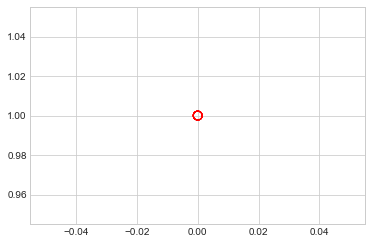

In [229]:
input_data = generate_rescaled_inputs(data)
predicted_output = generate_predictions(data, 0)
fh, ffa = compute_error_metrics(input_data, predicted_output)
plt.scatter(ffa, fh, s=80, facecolors='none', edgecolors='r')
plt.show()

[[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.97368421052

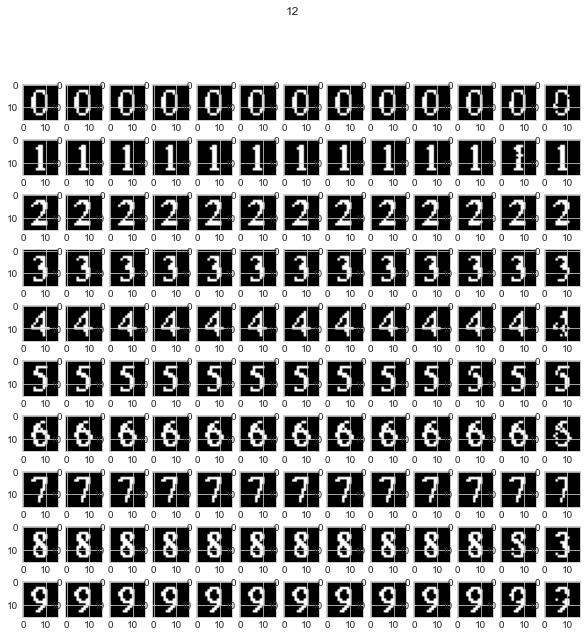

In [230]:
err = []
sigma = [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5, 1]
fig, axs = plt.subplots(10, 13, figsize=(10, 10))
for s in range(13):
    fig.suptitle(s)
    noisy_data = []
    for d in data:
        nd = add_noise(np.copy(d), sigma[s])
        noisy_data.append(normalize(nd))
    target_values = generate_rescaled_inputs(data)
    predicted_values = generate_predictions(noisy_data, 0)
    for i in range(10):
        axs[i, s].imshow(predicted_values[i].reshape(16, 16))
    fh, ffa = compute_error_metrics(target_values, predicted_values)
    err.append([fh, ffa])
print(err)

In [231]:
for test in range(0, 600, 10):
    mlp_model = MLP()
    
    criterion = torch.nn.MSELoss(size_average = False)
    optimizer = torch.optim.SGD(mlp_model.parameters(), lr = 0.001)
    for epoch in range(test):
    
        # Forward pass: Compute predicted y by passing x to the model
        pred_y = mlp_model(x_data)
    
        # Compute loss
        loss = criterion(pred_y, y_data)
    
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('epoch {}'.format(test))
    
    target_values = generate_rescaled_inputs(data)
    predicted_values = generate_predictions(data, 1)
    fh, ffa = compute_error_metrics(target_values, predicted_values)
    print('ffa=', np.mean(ffa))
    print('fh=', np.mean(fh))

epoch 0
ffa= 0.48493014641771043
fh= 0.5855428569719094
epoch 10
ffa= 0.03525490909239172
fh= 0.5404156652347039
epoch 20
ffa= 0.030467858494613077
fh= 0.5854327522037774
epoch 30
ffa= 0.030463405440422503
fh= 0.5985252898521235
epoch 40
ffa= 0.02866959468302228
fh= 0.5917489463461976
epoch 50
ffa= 0.027767464971760174
fh= 0.6027861144165534
epoch 60
ffa= 0.0264815484949761
fh= 0.6107877493282053
epoch 70
ffa= 0.0233673190245975
fh= 0.6380612003354025
epoch 80
ffa= 0.022955930343017097
fh= 0.6332679720539709
epoch 90
ffa= 0.02075180624676819
fh= 0.679360395447372
epoch 100
ffa= 0.01989547119660054
fh= 0.6767639103681147
epoch 110
ffa= 0.017236031352773493
fh= 0.7226589827743845
epoch 120
ffa= 0.016389954110264723
fh= 0.7286830329905849
epoch 130
ffa= 0.015449978595271812
fh= 0.7562759717769033
epoch 140
ffa= 0.010583559089063945
fh= 0.783752258843454
epoch 150
ffa= 0.009675879372251832
fh= 0.7920581034772723
epoch 160
ffa= 0.012396051140231646
fh= 0.7978927554667231
epoch 170
ffa= 0.01

In [232]:
#The ffa and fh for input data becomes stable around 500 epochs so number of epochs chosen = 500
mlp_model = MLP()

criterion = torch.nn.MSELoss(size_average = False)
optimizer = torch.optim.SGD(mlp_model.parameters(), lr = 0.001)
for epoch in range(500):

    # Forward pass: Compute predicted y by passing x to the model
    pred_y = mlp_model(x_data)

    # Compute loss
    loss = criterion(pred_y, y_data)

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

[[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[1.0, 1.0, 1.0, 0.9655172413793104, 1.0, 0.9

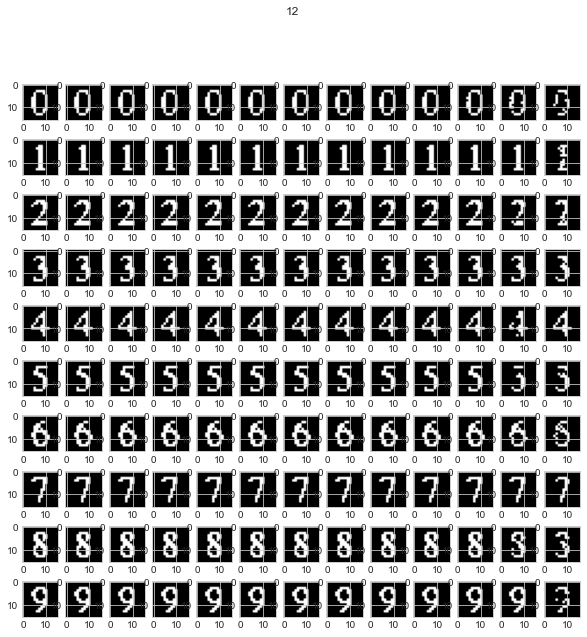

In [233]:
err = []
sigma = [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5, 1]
fig, axs = plt.subplots(10, 13, figsize=(10, 10))
for s in range(13):
    fig.suptitle(s)
    noisy_data = []
    for d in data:
        nd = add_noise(np.copy(d), sigma[s])
        noisy_data.append(normalize(nd))
    target_values = generate_rescaled_inputs(data)
    predicted_values = generate_predictions(noisy_data, 1)
    for i in range(10):
        axs[i, s].imshow(predicted_values[i].reshape(16, 16))
    fh, ffa = compute_error_metrics(target_values, predicted_values)
    err.append([fh, ffa])
print(err)